In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from enum import Enum
from collections import deque, Counter

In [2]:
class StationMode(Enum):
    NORMAL = 0
    HIGH_LOAD = 1
    CRITICAL = 2


In [3]:
class Vehicle:
    def __init__(self, arrival_time, service_time, priority):
        self.arrival_time = arrival_time
        self.service_time = service_time
        self.priority = priority
        self.start_time = None
        self.finish_time = None


In [4]:
class ArrivalRateMonitor:
    def __init__(self, window_size=50, spike_multiplier=2.5):
        self.window_size = window_size
        self.spike_multiplier = spike_multiplier
        self.history = deque(maxlen=window_size)
        self.baseline_mean = 0

    def update(self, arrival_occurred):
        self.history.append(arrival_occurred)

        if len(self.history) == self.window_size:
            current_rate = sum(self.history) / self.window_size
            if self.baseline_mean == 0:
                self.baseline_mean = current_rate
            else:
                self.baseline_mean = 0.99 * self.baseline_mean + 0.01 * current_rate

            if current_rate > self.spike_multiplier * max(self.baseline_mean, 1e-5):
                return True

        return False


In [5]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
class DecisionEngine:
    def __init__(self, state_dim=8, max_queue_considered=10):

        self.max_queue = max_queue_considered
        self.action_dim = max_queue_considered
        self.gamma = 0.99

        self.model = DQN(state_dim, self.action_dim)
        self.target = DQN(state_dim, self.action_dim)
        self.target.load_state_dict(self.model.state_dict())

        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.memory = deque(maxlen=5000)

        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05

    def select_action(self, state, valid_actions):

        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state_tensor).detach().numpy()[0]

        masked_q = [-1e9] * self.action_dim
        for a in valid_actions:
            masked_q[a] = q_values[a]

        return int(np.argmax(masked_q))

    def store(self, transition):
        self.memory.append(transition)

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_vals = self.model(states)
        next_q = self.target(next_states)

        target = rewards + self.gamma * torch.max(next_q, dim=1)[0] * (1 - dones)
        selected = q_vals.gather(1, actions.unsqueeze(1)).squeeze()

        loss = nn.MSELoss()(selected, target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min,
                           self.epsilon * self.epsilon_decay)

    def update_target(self):
        self.target.load_state_dict(self.model.state_dict())


In [7]:
class LoadAnomalyMonitor:
    def __init__(self, overload_threshold=0.9, critical_queue=20):
        self.overload_threshold = overload_threshold
        self.critical_queue = critical_queue

    def evaluate(self, station):
        utilization = station.total_busy_time / (
            len(station.chargers) * max(station.current_time, 1)
        )

        overload = utilization > self.overload_threshold
        critical = len(station.queue) > self.critical_queue

        return overload, critical

In [8]:
class ModeController:
    def __init__(self):
        self.mode = StationMode.NORMAL

    def update(self, overload, critical, coordinator_alive=True):
        if not coordinator_alive:
            self.mode = StationMode.FAILSAFE
            return

        if critical:
            self.mode = StationMode.CRITICAL
        elif overload:
            self.mode = StationMode.HIGH_LOAD
        else:
            self.mode = StationMode.NORMAL


In [9]:
class AdmissionController:
    def allow(self, vehicle, mode):

        if mode == StationMode.CRITICAL:
            if vehicle.priority == 3:
                return False

        if mode == StationMode.FAILSAFE:
            if vehicle.priority == 3:
                return False

        return True

In [10]:
class StationAgent:

    def __init__(self, n_chargers=2):

        self.n_chargers = n_chargers
        self.chargers = [None] * n_chargers
        self.queue = []
        self.current_time = 0

        self.total_busy_time = 0
        self.completed = []
        self.rejected = 0

        self.mode = StationMode.NORMAL
        self.mode_history = []

        self.arrival_monitor = ArrivalRateMonitor()
        self.rl_engine = DecisionEngine()
        self.queue_history = []
        self.critical_time = 0
        self.arrival_count = 0


    # -------------------------

    def get_state(self):

        queue_len = len(self.queue)
        utilization = self.total_busy_time / (
            self.n_chargers * max(self.current_time, 1)
        )

        p1 = sum(v.priority == 1 for v in self.queue) / max(queue_len, 1)
        p2 = sum(v.priority == 2 for v in self.queue) / max(queue_len, 1)
        p3 = sum(v.priority == 3 for v in self.queue) / max(queue_len, 1)

        spike_flag = 1 if self.mode != StationMode.NORMAL else 0

        return np.array([
            queue_len,
            utilization,
            p1,
            p2,
            p3,
            spike_flag,
            self.mode.value,
            self.n_chargers
        ], dtype=np.float32)

    # -------------------------

    def update_mode(self, spike_detected):

        if spike_detected:
            self.mode = StationMode.HIGH_LOAD

        if len(self.queue) > 25:
            self.mode = StationMode.CRITICAL

        if len(self.queue) < 10:
            self.mode = StationMode.NORMAL

        self.mode_history.append(self.mode)

    # -------------------------

    def arrival(self, vehicle):
        self.arrival_count += 1
        spike = self.arrival_monitor.update(1)
        self.update_mode(spike)

        if self.mode == StationMode.CRITICAL and vehicle.priority == 3:
            self.rejected += 1
            return

        self.queue.append(vehicle)

    # -------------------------

    def dispatch(self):

        if not self.queue:
            return

        state = self.get_state()

        valid_actions = list(range(min(len(self.queue), 10)))

        action = self.rl_engine.select_action(state, valid_actions)

        vehicle = self.queue.pop(action)

        vehicle.start_time = self.current_time
        vehicle.finish_time = self.current_time + vehicle.service_time

        for i in range(self.n_chargers):
            if self.chargers[i] is None:
                self.chargers[i] = vehicle
                break

        wait = vehicle.start_time - vehicle.arrival_time
        
        wait_penalty = - (wait / 10.0)
        
        if vehicle.priority == 1:
            fair_bonus = 2.0
        elif vehicle.priority == 2:
            fair_bonus = 1.0
        else:
            fair_bonus = 0.0
        
        queue_penalty = -0.1 * len(self.queue)
        
        if self.mode == StationMode.CRITICAL:
            mode_penalty = -2.0
        elif self.mode == StationMode.HIGH_LOAD:
            mode_penalty = -0.5
        else:
            mode_penalty = 0.0
        
        throughput_bonus = 1.0
        
        reward = (
            wait_penalty +
            fair_bonus +
            queue_penalty +
            mode_penalty +
            throughput_bonus
        )


    # -------------------------

    def step(self):

        self.current_time += 1

        for i in range(self.n_chargers):
            vehicle = self.chargers[i]
            if vehicle is not None:
                self.total_busy_time += 1
                if self.current_time >= vehicle.finish_time:
                    self.completed.append(vehicle)
                    self.chargers[i] = None

        for i in range(self.n_chargers):
            if self.chargers[i] is None:
                self.dispatch()
        self.queue_history.append(len(self.queue))

        if self.mode == StationMode.CRITICAL:
            self.critical_time += 1


    # -----------------------------------------
    # PERFORMANCE METRICS
    # -----------------------------------------

    def utilization(self):
        return self.total_busy_time / (
            self.n_chargers * max(self.current_time, 1)
        )

    def average_wait_time(self):
        waits = [
            v.start_time - v.arrival_time
            for v in self.completed
            if v.start_time is not None
        ]
        return np.mean(waits) if waits else 0

    def p95_wait_time(self):
        waits = [
            v.start_time - v.arrival_time
            for v in self.completed
            if v.start_time is not None
        ]
        return np.percentile(waits, 95) if waits else 0

    def mode_statistics(self):
        return Counter(self.mode_history)

    # -----------------------------------------
    # ADVANCED SYSTEM METRICS
    # -----------------------------------------
    
    def max_queue_length(self):
        return max(self.queue_history) if self.queue_history else 0
    
    
    def time_in_critical_ratio(self):
        return self.critical_time / max(self.current_time, 1)
    
    
    def queue_growth_rate(self):
        if len(self.queue_history) < 2:
            return 0
        return (self.queue_history[-1] - self.queue_history[0]) / len(self.queue_history)
    
    
    def stability_index(self):
        """
        Stability index = 1 / (1 + variance of queue length)
        Higher = more stable
        """
        if len(self.queue_history) < 2:
            return 1
        variance = np.var(self.queue_history)
        return 1 / (1 + variance)
    
    
    def throughput(self):
        return len(self.completed) / max(self.current_time, 1)



In [11]:
class NoRejectionStationAgent(StationAgent):

    def arrival(self, vehicle):
        # Still detect spike for monitoring,
        # but DO NOT reject
        spike = self.arrival_monitor.update(1)
        self.update_mode(spike)

        # Always allow
        self.queue.append(vehicle)


In [12]:
def run_sim(sim_time=2000, arrival_rate=0.7):

    station = StationAgent()

    for t in range(sim_time):

        if np.random.rand() < arrival_rate:
            service = np.random.exponential(6)
            priority = np.random.choice([1,2,3], p=[0.1,0.2,0.7])
            vehicle = Vehicle(t, service, priority)
            station.arrival(vehicle)

        station.step()

        if t % 200 == 0:
            station.rl_engine.update_target()

    return station


In [13]:
# =========================================================
# RUN EXPERIMENT
# =========================================================

station = run_sim()

print("Completed:", len(station.completed))
print("Rejected:", station.rejected)



print("==== PERFORMANCE METRICS ====")
print("Completed Vehicles:", len(station.completed))
print("Rejected Vehicles:", station.rejected)
print("Utilization:", round(station.utilization(), 3))
print("Average Wait:", round(station.average_wait_time(), 3))
print("P95 Wait:", round(station.p95_wait_time(), 3))
print("Mode Distribution:", station.mode_statistics())


Completed: 616
Rejected: 804
==== PERFORMANCE METRICS ====
Completed Vehicles: 616
Rejected Vehicles: 804
Utilization: 0.999
Average Wait: 62.867
P95 Wait: 135.5
Mode Distribution: Counter({<StationMode.CRITICAL: 2>: 1180, <StationMode.NORMAL: 0>: 261})


In [14]:
def run_comparison(sim_time=2000, arrival_rate=0.7, seed=42):

    np.random.seed(seed)
    random.seed(seed)

    hybrid = StationAgent()
    baseline = NoRejectionStationAgent()

    for t in range(sim_time):

        arrival_flag = np.random.rand() < arrival_rate

        if arrival_flag:
            service = np.random.exponential(6)
            priority = np.random.choice([1,2,3], p=[0.1,0.2,0.7])

            v1 = Vehicle(t, service, priority)
            v2 = Vehicle(t, service, priority)

            hybrid.arrival(v1)
            baseline.arrival(v2)

        hybrid.step()
        baseline.step()

        if t % 200 == 0:
            hybrid.rl_engine.update_target()
            baseline.rl_engine.update_target()

    return hybrid, baseline


In [15]:
hybrid, baseline = run_comparison()

print("====== HYBRID SYSTEM ======")
print("Completed:", len(hybrid.completed))
print("Rejected:", hybrid.rejected)
print("Avg Wait:", round(hybrid.average_wait_time(), 2))
print("P95 Wait:", round(hybrid.p95_wait_time(), 2))

print("\n====== NO REJECTION BASELINE ======")
print("Completed:", len(baseline.completed))
print("Rejected:", baseline.rejected)
print("Avg Wait:", round(baseline.average_wait_time(), 2))
print("P95 Wait:", round(baseline.p95_wait_time(), 2))


====== HYBRID SYSTEM ======
Completed: 604
Rejected: 777
Avg Wait: 65.37
P95 Wait: 127.55

====== NO REJECTION BASELINE ======
Completed: 603
Rejected: 0
Avg Wait: 554.46
P95 Wait: 1073.6


In [16]:
def print_metrics(label, station):

    print(f"\n====== {label} ======")
    print("Completed:", len(station.completed))
    print("Rejected:", station.rejected)
    print("Throughput:", round(station.throughput(), 3))
    print("Avg Wait:", round(station.average_wait_time(), 2))
    print("P95 Wait:", round(station.p95_wait_time(), 2))
    print("Max Queue:", station.max_queue_length())
    print("Critical Ratio:", round(station.time_in_critical_ratio(), 3))
    print("Queue Growth Rate:", round(station.queue_growth_rate(), 4))
    print("Stability Index:", round(station.stability_index(), 4))


In [17]:
def throughput_curve(arrival_rates, sim_time=2000):

    hybrid_throughput = []
    baseline_throughput = []

    for rate in arrival_rates:

        h, b = run_comparison(sim_time=sim_time,
                              arrival_rate=rate,
                              seed=42)

        hybrid_throughput.append(h.throughput())
        baseline_throughput.append(b.throughput())

    return hybrid_throughput, baseline_throughput


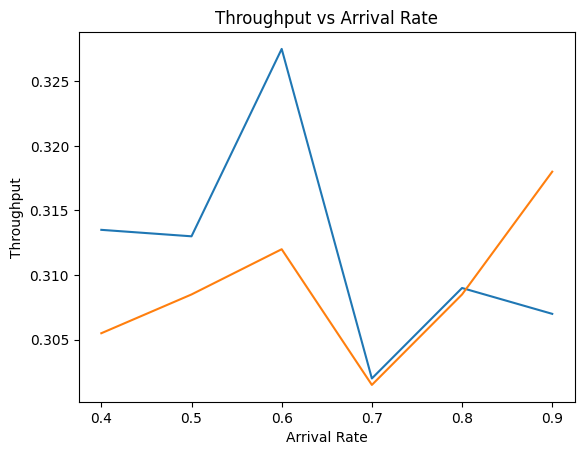

In [18]:
arrival_rates = np.linspace(0.4, 0.9, 6)

h_tp, b_tp = throughput_curve(arrival_rates)

plt.figure()
plt.plot(arrival_rates, h_tp)
plt.plot(arrival_rates, b_tp)
plt.title("Throughput vs Arrival Rate")
plt.xlabel("Arrival Rate")
plt.ylabel("Throughput")
plt.show()


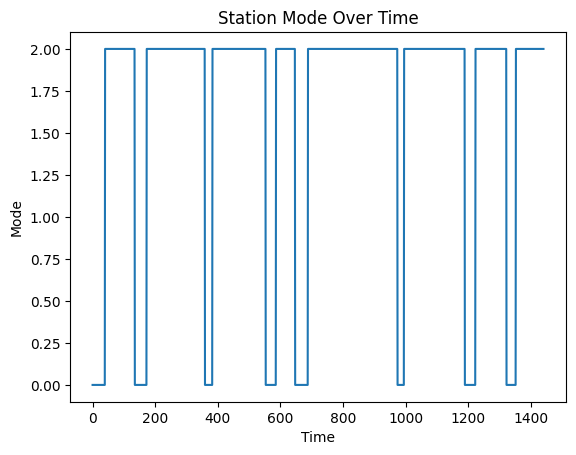

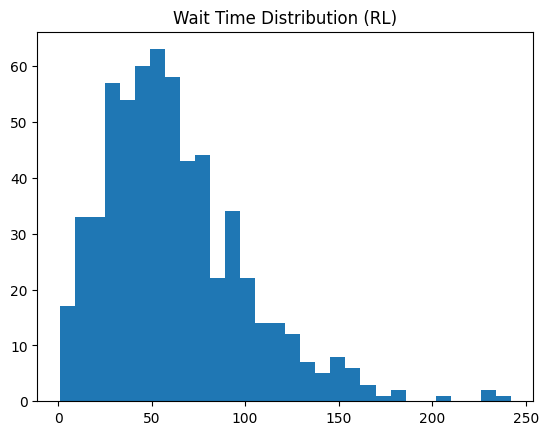

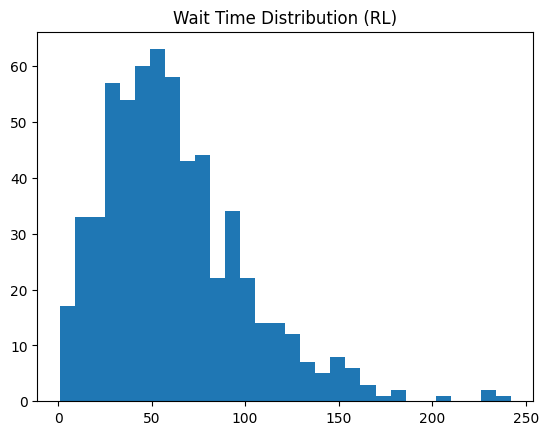

In [19]:
# =========================================================
# VISUALIZATION
# =========================================================

modes = [m.value for m in station.mode_history]

plt.figure()
plt.plot(modes)
plt.title("Station Mode Over Time")
plt.xlabel("Time")
plt.ylabel("Mode")
plt.show()

waits = [
    v.start_time - v.arrival_time
    for v in station.completed
]

plt.figure()
plt.hist(waits, bins=30)
plt.title("Wait Time Distribution (RL)")
plt.show()
waits = [
    v.start_time - v.arrival_time
    for v in station.completed
]

plt.figure()
plt.hist(waits, bins=30)
plt.title("Wait Time Distribution (RL)")
plt.show()
